In [1]:
# Install pycocotools package
import os
!mkdir /kaggle/working/packages
!cp -r /kaggle/input/pycocotools/* /kaggle/working/packages
os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
!python setup.py install
!pip install . --no-index --find-links /kaggle/working/packages/
os.chdir("/kaggle/working")

running install
/opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.linux-x86_64-3.10
cre

In [2]:
import base64
import glob
import json
import typing as t
import zlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pycocotools import _mask as coco_mask
from scipy import ndimage
from scipy.ndimage import label
from skimage.morphology import opening, remove_small_objects, square
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import backend as K, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Dropout, Input, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
train_path = "/kaggle/input/hubmap-hacking-the-human-vasculature/train/*"
test_path = "/kaggle/input/hubmap-hacking-the-human-vasculature/test/*"

train = glob.glob(train_path)
test = glob.glob(test_path)

# Create our image map for our train data and test data
image_map = {impath.split('/')[-1].split('.')[0]: impath for impath in train}
image_map_test = {impath.split('/')[-1].split('.')[0]: impath for impath in test}

In [4]:
print(image_map_test)

{'72e40acccadf': '/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif'}


In [5]:
def my_preprocessing_func(img):
    # Normalization (assuming the image is in uint8 format)
    img = img / 255.0
    return img

In [6]:
# define our dice_coef and loss functions
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
def combined_dice_bce_loss(y_true, y_pred, weight=0.5):
    dice_loss_value = dice_loss(y_true, y_pred)
    bce_loss_value = binary_crossentropy(y_true, y_pred)
    return weight * bce_loss_value + (1 - weight) * dice_loss_value

In [7]:
model = load_model('/kaggle/input/resnet50-small-pretrained/model-Final-smallRes50.h5', custom_objects={'dice_coef': dice_coef, 'combined_dice_bce_loss': combined_dice_bce_loss})

In [8]:
def process_mask(predicted_mask, selem_size=3, min_size=100):
    """
    Perform morphological operations and small object removal on the predicted mask.

    Args:
    predicted_mask (numpy.ndarray): The predicted mask.
    selem_size (int, optional): The size of the structure element for morphological operations. Default is 3.
    min_size (int, optional): The minimum size of the objects to be retained. Default is 100.

    Returns:
    final_mask (numpy.ndarray): The processed mask.
    """

    # Ensure that the input is a 2D array
    if len(predicted_mask.shape) > 2:
        predicted_mask = predicted_mask.squeeze()
    # Create structure element
    selem = square(selem_size)

    # Perform morphological operation (opening)
    opened_mask = opening(predicted_mask, selem)

    # Label connected components
    labeled_array, num_features = ndimage.label(opened_mask)

    # Create an empty mask to hold the remaining components
    final_mask = np.zeros_like(opened_mask)

    for i in range(1, num_features + 1):
        component_size = np.sum(labeled_array == i)
        if component_size >= min_size:
            final_mask += (labeled_array == i)


    return opened_mask

In [9]:
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != bool:
      raise ValueError(
          "encode_binary_mask expects a binary mask, received dtype == %s" %
          mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
      raise ValueError(
          "encode_binary_mask expects a 2d mask, received shape == %s" %
          mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [10]:
def plot_predictions(image, predicted_mask):
    # Squeeze the image to remove unnecessary dimensions
    image = np.squeeze(image)

    # Create overlay image
    overlay = image.copy()

    # Create a 3D mask with 3 channels
    predicted_mask_3d = np.stack((predicted_mask,)*3, axis=-1)
    
    # Apply the mask to the overlay
    for i in range(3):  # For each channel
        overlay[predicted_mask_3d[:, :, i] > 0, i] = 255 if i == 1 else 0

    # Display image, mask and overlay
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')  # Turn off axis for image
    ax[1].imshow(predicted_mask, cmap='gray')
    ax[1].set_title('Predicted Blood Vessel Mask')
    ax[1].axis('off')  # Turn off axis for mask
    ax[2].imshow(overlay)
    ax[2].set_title('Overlay')
    ax[2].axis('off')  # Turn off axis for overlay
    plt.show()

1/1 [==============================] - 10s 10s/step


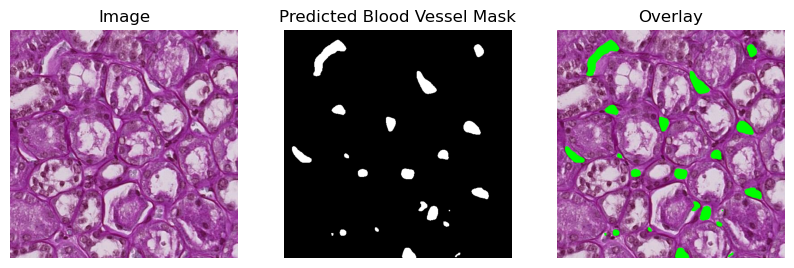

1/1 [==============================] - 0s 37ms/step


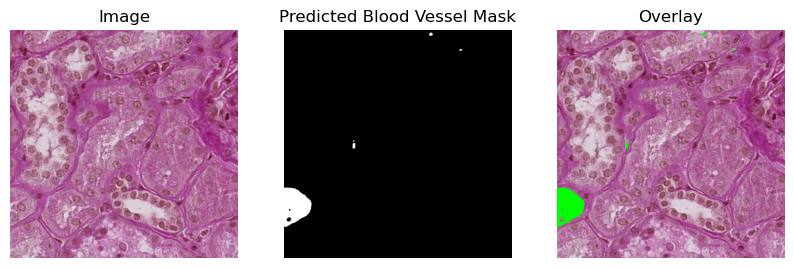

1/1 [==============================] - 0s 34ms/step


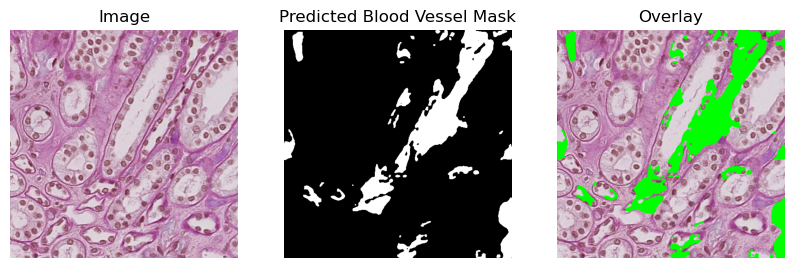

1/1 [==============================] - 0s 36ms/step


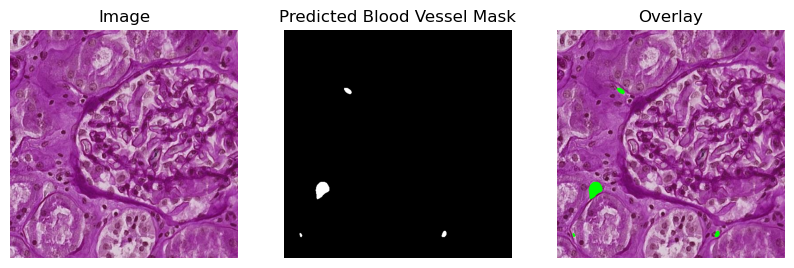

1/1 [==============================] - 0s 36ms/step


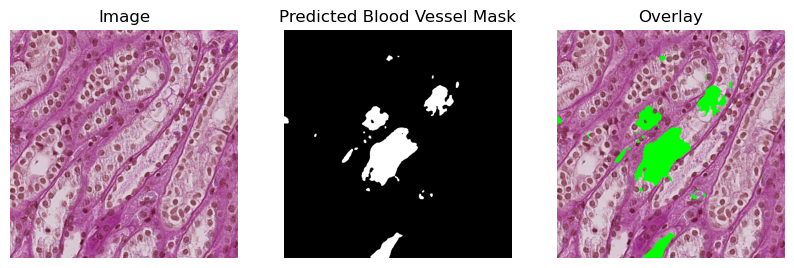

1/1 [==============================] - 0s 37ms/step


In [12]:
# Initialize an empty list to hold your submission data
submission_data = []

# For each test image
for idx, (image_id, image_path) in enumerate(image_map.items()):
    # Break the loop after processing the first 10 images
    if idx > 25:
        break

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = my_preprocessing_func(image) # run image through our preprocessing function)
    image = np.expand_dims(image, axis=0)  # expand dimensions for model

    # Generate the predicted mask
    predicted_mask = model.predict(image)

    # Cast the mask to bool
    binary_predictions = (predicted_mask > 0.5).astype(int)
    predicted_mask =  binary_predictions.squeeze()
    

    # Post-process the predicted mask
    process_predicted_mask = process_mask(predicted_mask)

    # Plot predictions if first 5
    if idx < 5:
        plot_predictions(image, process_predicted_mask)

    
    # Convert the predicted mask to binary
    binary_predicted_mask = np.where(process_predicted_mask > 0, 1, 0)

    # Compute the confidence score for the prediction
    confidence = 0.5  # Or some other value

    # Cast the mask to bool
    binary_predicted_mask_bool = binary_predicted_mask.astype(bool)
    # Encode the mask
    encoded_mask = encode_binary_mask(binary_predicted_mask_bool)



    # Prepare the prediction string
    prediction_string = f'0 {confidence} {encoded_mask.decode()}'
    
    # Append this image's data to the submission data
    submission_data.append([image_id, predicted_mask.shape[0], predicted_mask.shape[1], prediction_string])
    

# Create a DataFrame from the submission data
submission_df = pd.DataFrame(submission_data, columns=['id', 'height', 'width', 'prediction_string'])

# Write the DataFrame to a CSV file for submission
submission_df.to_csv('submission.csv', index=False)